In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier

In [2]:
# === Step 1: Load Data ===
file_path = '../data/MachineLearningRating_v3.txt'
df = pd.read_csv(file_path, sep='|', low_memory=False)

In [3]:
# === Step 2: Basic Cleaning ===
df = df.drop_duplicates()
df = df[df['TotalClaims'].notna()]
# Filter subset where claim > 0
claims_df = df[df['TotalClaims'] > 0].copy()

In [4]:
# === Step 3: Feature Selection ===
numerical_features = [
    'cubiccapacity', 'kilowatts', 'NumberOfDoors', 'CapitalOutstanding',
    'SumInsured', 'CalculatedPremiumPerTerm'
]
categorical_features = [
    'VehicleType', 'make', 'Model', 'Province', 'ItemType', 'CoverGroup', 'Product'
]

In [5]:
# === Step 4: Data Preprocessing ===
def preprocess_data(df, numerical_features, categorical_features):
    df = df[numerical_features + categorical_features + ['TotalClaims', 'TotalPremium', 'AtLeastOneClaim']].copy()

    # Clean numeric columns: remove thousands separators and fix decimal commas
    for col in numerical_features:
        df[col] = df[col].astype(str).str.replace('.', '', regex=False)  # Remove thousands separator (if used as .)
        df[col] = df[col].str.replace(',', '.', regex=False)             # Replace decimal comma with dot
        df[col] = pd.to_numeric(df[col], errors='coerce')                # Convert to float, set bad values to NaN

    # Impute numeric
    num_imputer = SimpleImputer(strategy='median')
    df[numerical_features] = num_imputer.fit_transform(df[numerical_features])

    # Impute categorical
    df[categorical_features] = df[categorical_features].fillna('Missing')

    # One-hot encode categoricals
    df = pd.get_dummies(df, columns=categorical_features, drop_first=True)
    return df

# Add binary target to both datasets
df['AtLeastOneClaim'] = (df['TotalClaims'] > 0).astype(int)
claims_df['AtLeastOneClaim'] = (claims_df['TotalClaims'] > 0).astype(int)

# Process both regression and classification datasets
reg_df = preprocess_data(claims_df, numerical_features, categorical_features)
clf_df = preprocess_data(df, numerical_features, categorical_features)

In [6]:
# === Step 5: Split Data ===
def split_data(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return train_test_split(X, y, test_size=0.2, random_state=42)

# For claim severity regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = split_data(reg_df, 'TotalClaims')

# For claim classification
X_train_clf, X_test_clf, y_train_clf, y_test_clf = split_data(clf_df, 'AtLeastOneClaim')

In [7]:
# === Step 6: Model Definitions ===
models_reg = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

models_clf = {
    'Random Forest Classifier': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost Classifier': XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss')
}

In [8]:
# === Step 7: Model Training & Evaluation ===
def evaluate_regression(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f'\n{name} - RMSE: {rmse:.2f}, R2: {r2:.2f}')
    return model

def evaluate_classification(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f'\n{name} Classification Report:\n{classification_report(y_test, preds)}')
    return model

print("=== Regression Models ===")
best_reg_model = None
best_r2 = -np.inf
for name, model in models_reg.items():
    trained_model = evaluate_regression(name, model, X_train_reg, y_train_reg, X_test_reg, y_test_reg)
    r2 = r2_score(y_test_reg, trained_model.predict(X_test_reg))
    if r2 > best_r2:
        best_r2 = r2
        best_reg_model = trained_model

print("\n=== Classification Models ===")
for name, model in models_clf.items():
    evaluate_classification(name, model, X_train_clf, y_train_clf, X_test_clf, y_test_clf)

=== Regression Models ===

Linear Regression - RMSE: 42886.67, R2: -0.14

Random Forest - RMSE: 36352.16, R2: 0.18

XGBoost - RMSE: 39067.13, R2: 0.05

=== Classification Models ===

Random Forest Classifier Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199439
           1       1.00      1.00      1.00       581

    accuracy                           1.00    200020
   macro avg       1.00      1.00      1.00    200020
weighted avg       1.00      1.00      1.00    200020



c:\Users\hlina\insurance-eda-project-clean\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [09:28:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Classifier Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199439
           1       1.00      0.00      0.00       581

    accuracy                           1.00    200020
   macro avg       1.00      0.50      0.50    200020
weighted avg       1.00      1.00      1.00    200020



cubiccapacity                                 float64
kilowatts                                     float64
NumberOfDoors                                 float64
CapitalOutstanding                            float64
SumInsured                                    float64
                                               ...   
CoverGroup_Deposit Cover                      float64
CoverGroup_Income Protector                   float64
CoverGroup_Motor Comprehensive                float64
Product_Mobility Commercial Cover: Monthly    float64
Product_Mobility Metered Taxis: Monthly       float64
Length: 193, dtype: object

=== SHAP Analysis for Best Regression Model ===


 98%|===================| 549/558 [00:31<00:00]        

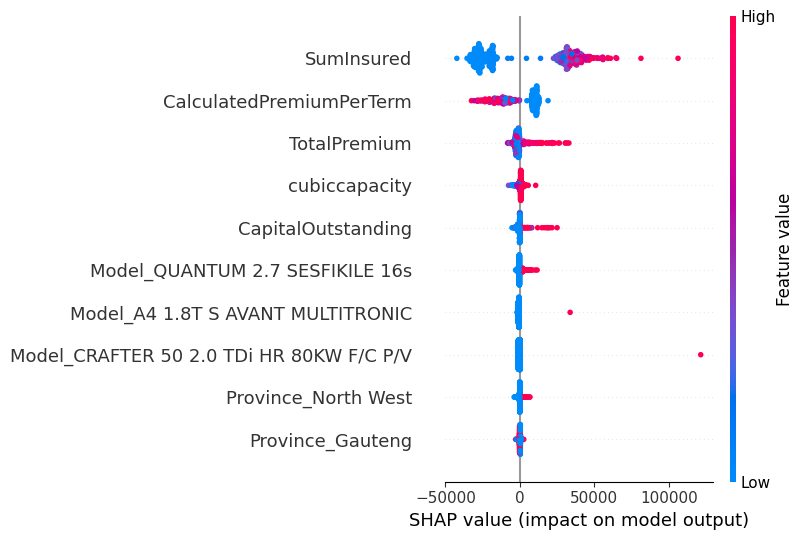

In [16]:
# Convert all data to float64 (avoids SHAP dtype issues, especially with bools)
X_train_reg = X_train_reg.astype('float64')
X_test_reg = X_test_reg.astype('float64')

print(X_train_reg.dtypes)

print("\n=== SHAP Analysis for Best Regression Model ===")
explainer = shap.Explainer(best_reg_model, X_train_reg)
shap_values = explainer(X_test_reg)

shap.summary_plot(shap_values, X_test_reg, max_display=10)



=== SHAP Force Plot ===

=== SHAP Waterfall Plot ===


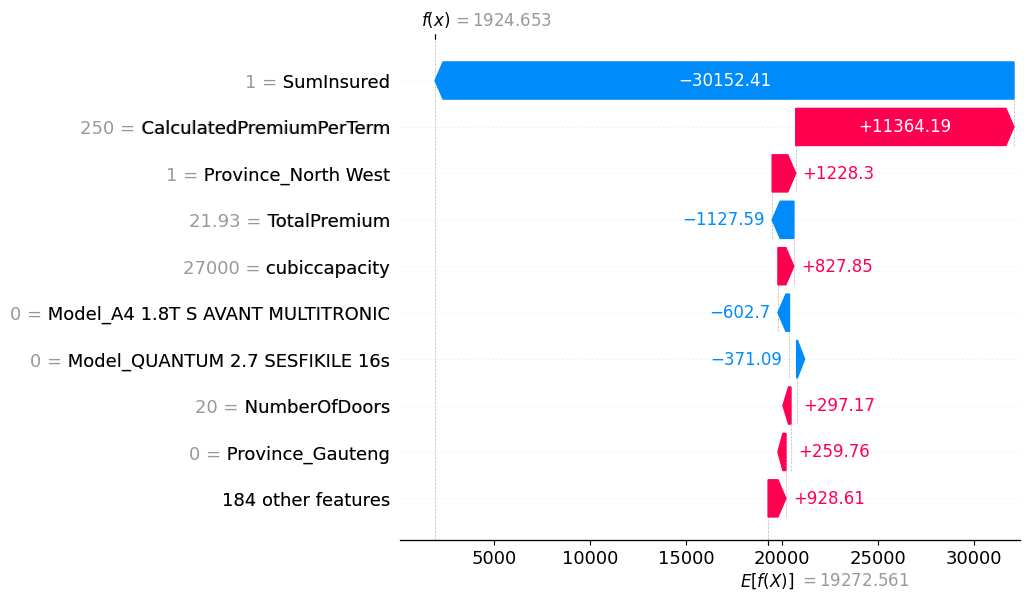


=== SHAP Bar Plot (Global Feature Importance) ===


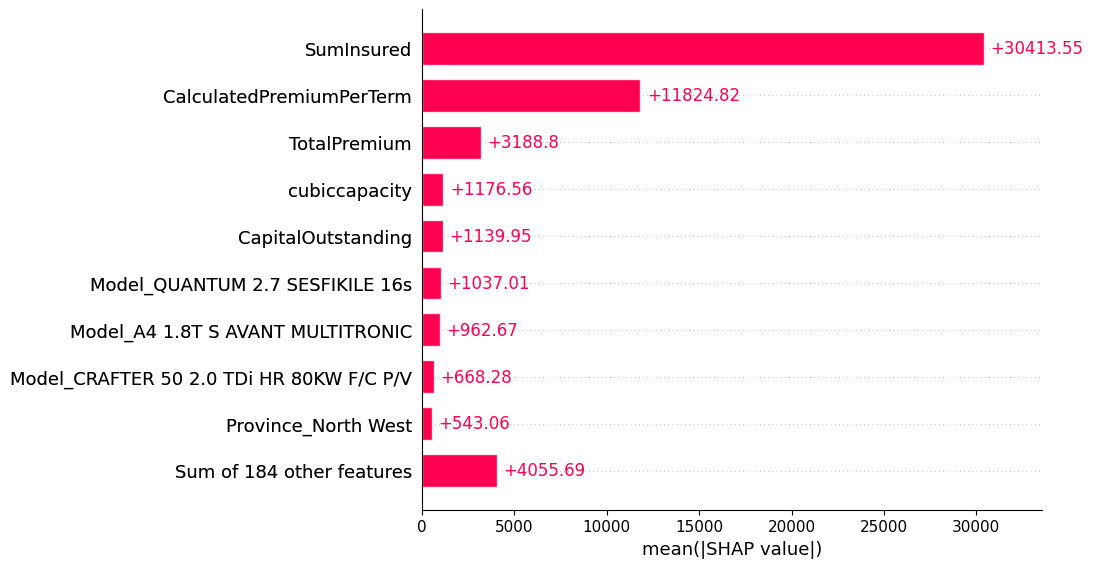


=== SHAP Dependence Plots (Feature Impact Trend) ===


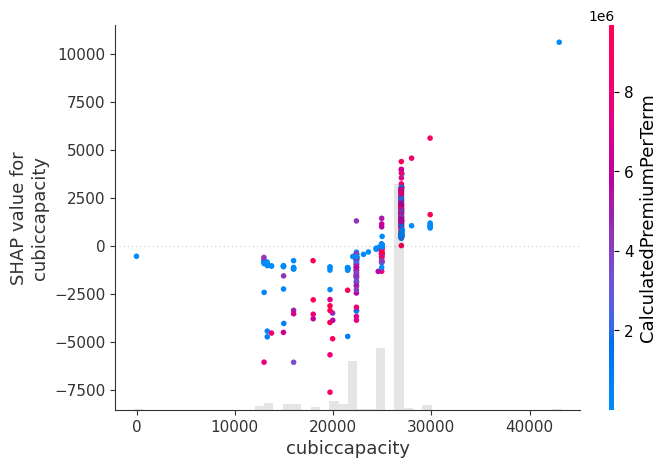

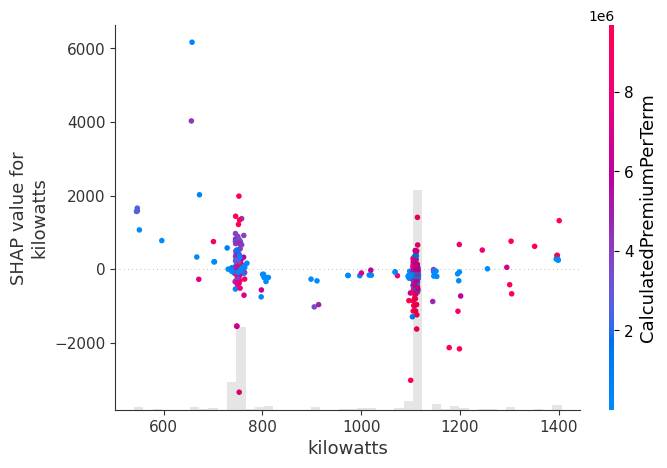

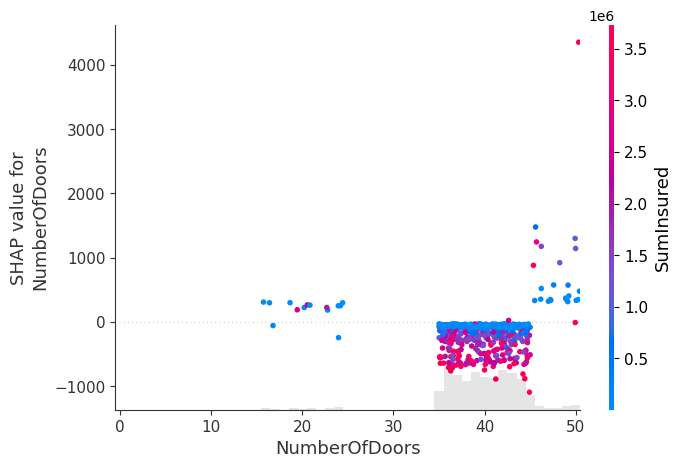

In [17]:
shap.initjs()

print("\n=== SHAP Force Plot ===")
shap.plots.force(shap_values[0], matplotlib=False)  # Individual prediction

print("\n=== SHAP Waterfall Plot ===")
shap.plots.waterfall(shap_values[0])  # Detailed contribution of features

print("\n=== SHAP Bar Plot (Global Feature Importance) ===")
shap.plots.bar(shap_values)  # Top global features

print("\n=== SHAP Dependence Plots (Feature Impact Trend) ===")
for feature in X_test_reg.columns[:3]:
    shap.plots.scatter(shap_values[:, feature], color=shap_values)
